<a href="https://colab.research.google.com/github/erezimm/ML-ML/blob/master/GNN_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Main notebook, to be run on Google Colab

In [ ]:
!pip install dgl

import dgl
import dgl.function as fn
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
from torch.utils.data import Dataset, DataLoader
import glob
import json
from tqdm.notebook import tqdm
import torch.optim as optim
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt

### Download data sets (folders with text files) from our github

In [ ]:
import zipfile
import requests
from os.path import isfile

zipname = 'sets.zip'
if not isfile(zipname):
    url = 'fromgithub.com/sets.zip'
    r = requests.get(url)
    with open(zipname, 'wb') as zf:
        zf.write(r.content)

    with zipfile.ZipFile(zipname) as zf:
        zf.extractall('.')
    
training_path = '/content/training_set'
validation_path = '/content/validation_set'

### the custom dataset object will load the text files, and then convert the graphs to DGL graphs

Each node is a data point, i.e. node features are days since start, mag, magerr

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, path):
        filelist = glob.glob(path+'/*')
        
        self.graphs = []
        for fname in tqdm(filelist):
            with open(fname) as jfile:
                graph = nx.node_link_graph(json.load(jfile))
                g = dgl.DGLGraph()
                g.from_networkx(graph,node_attrs=['node_features'],edge_attrs=['distance','on_path'])
                
                self.graphs.append(g)
        
    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        return self.graphs[idx], self.graphs[idx].edata['on_path']

In [ ]:
train_ds = CustomDataset(path_to_ds)
test_ds = CustomDataset(path_to_test_ds)

In [ ]:
graph_ds = train_ds
graph_ds[495]

(DGLGraph(num_nodes=43, num_edges=172,
          ndata_schemes={'node_features': Scheme(shape=(2,), dtype=torch.float32)}
          edata_schemes={'distance': Scheme(shape=(), dtype=torch.float32), 'on_path': Scheme(shape=(), dtype=torch.int64)}),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
         0, 0, 0, 0]))

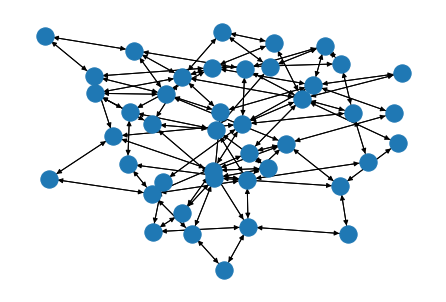

In [ ]:
nx.draw( dgl.to_networkx(graph_ds[495][0]) )

In [ ]:
def collate(samples):
    
    # The input `samples` is a list, a batch of whatever comes out of your dataset object
    
    graphs = [x[0] for x in samples]
    labels = [x[1] for x in samples]
    
    batched_graph = dgl.batch(graphs,node_attrs=['node_features'],edge_attrs=['distance'])
    targets = torch.cat(labels)
    
    return batched_graph, targets.unsqueeze(1).float()

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


#this function is the edge update function - 

class EdgeNetwork(nn.Module):
    def __init__(self, node_representation_size, edge_rep=1):
        super(EdgeNetwork, self).__init__()
        self.edge_rep = edge_rep

        n_in = 2*node_representation_size+5
        sizes = [100, self.edge_rep]

        layers = []
        layers.extend([nn.Linear(n_in, sizes[0]), nn.ReLU()])
        for i in range(len(sizes)-1):
            layers.extend([nn.Linear(sizes[i], sizes[i+1])])

        self.func = nn.Sequential(*layers)

        
    def forward(self, x):
        
        #your input x is an object with the following properties:
        # x.dst['node_features'], x.dst['node_hidden_state']
        # x.src['node_features'], x.src['node_hidden_state']
        # x.data['distance']
        
        #put them together with torch.cat

        # print( x.dst['node_features'].shape, x.dst['node_hidden_state'].shape,
        #                     x.src['node_features'].shape, x.src['node_hidden_state'].shape,
        #                     x.data['distance'].shape)

        output = torch.cat(( x.dst['node_features'], x.dst['node_hidden_state'],
                            x.src['node_features'], x.src['node_hidden_state'],
                            torch.unsqueeze(x.data['distance'],1) ), dim=1)
        
        #use a neural network to create an edge hidden represetation - 

        output = self.func(output)

        #you return a dictionary with what you want to "send" to the reciving node
        
        name = 'edge_class_prediction' if self.edge_rep==1 else 'edge hidden represetation'
        return {name: output }

    
class NodeNetwork(nn.Module):
    def __init__(self,  node_representation_size, edge_rep=1):
        super(NodeNetwork, self).__init__()

        n_in = edge_rep + node_representation_size + 2
        sizes = [node_representation_size]

        layers = []
        layers.extend([nn.Linear(n_in, sizes[0]), nn.ReLU()])
        for i in range(len(sizes)-1):
            layers.extend([nn.Linear(sizes[i], sizes[i+1]), nn.ReLU()])

        self.func = nn.Sequential(*layers)
    def forward(self, x):
        
        #this time your input x has:
        # x.mailbox['edge hidden represetation'] -> this is what you send with the edge update function above - 
        # it will have the size of the node neighborhood - 
        # (Batch size, number of nodes in neighborhood, edge hidden rep size), so you need to sum/mean over dim=1 
        # x.data['node_hidden_state'] and x.data['node_features'] (this is the existing state of your node)
        # you need to torch.cat the message sum, node hidden state, and node features 
        #- and then apply some fully connected neural network
        
        mb = torch.mean( x.mailbox['edge hidden represetation'] , dim=1 )

        # print( mb.shape, x.data['node_hidden_state'].shape, x.data['node_features'].shape )

        out = torch.cat((mb, x.data['node_hidden_state'], x.data['node_features']), dim=1)
        out = self.func(out)

        # return a new hidden state for the node
        return {'node_hidden_state': out }


class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        
        # you need to create a network that 
        # will initialize your node hidden state based only on the node features -
        n_in = 2

        node_representation_size, edge_rep = 100, 100
        sizes = [node_representation_size]

        layers = []
        layers.extend([nn.Linear(n_in, sizes[0]), nn.ReLU()])
        for i in range(len(sizes)-1):
            layers.extend([nn.Linear(sizes[i], sizes[i+1]), nn.ReLU()])

        self.node_init = nn.Sequential(*layers)
        


        self.edge_network = EdgeNetwork(node_representation_size, edge_rep)
        self.node_network = NodeNetwork(node_representation_size, edge_rep)
        
        #this edge classifier is also an edge update function - 
        #but it needs to return something of size 1 (the edge class prediction)
        #so either create a different model for this, or make the EdgeNetwork configurable
        self.edge_classifier = EdgeNetwork(node_representation_size, 1)
        
    def forward(self, g):
        
        g.ndata['node_hidden_state'] = self.node_init(g.ndata['node_features'])
        
        for i in range(20):
            g.update_all(self.edge_network,self.node_network)
            
        
        #we want to classify the edges - so finally apply your edge classifier -
        g.apply_edges(self.edge_classifier)
        
        #and extract its output 
        out = g.edata['edge_class_prediction']

        
        return out 

In [ ]:
net = Classifier()

data_loader = DataLoader(train_ds, batch_size=30, shuffle=True,
                         collate_fn=collate)

loss_func = nn.BCEWithLogitsLoss()

In [ ]:
if torch.cuda.is_available():
    print('Cuda on')
    device = torch.device('cuda')
else:
  print('No Cuda')
  device = torch.device('cpu')


net.to(device)

# optimizer = optim.SGD(net.parameters(), lr=0.01)
optimizer = optim.Adam(net.parameters(), lr=0.001)

Cuda on


In [ ]:
n_epochs = 50

for epoch in tqdm( range(n_epochs) ):
    net.train()
    losses = []
    for x,y in data_loader:
        if torch.cuda.is_available():
            x = x.to(torch.device('cuda'))
            y = y.cuda()

        optimizer.zero_grad()
        output = net(x)
        # print(output.shape, y.shape)

        loss = loss_func(output,y)

        losses.append(float(loss))

        loss.backward()
        optimizer.step()
    
    print(epoch, ':', np.mean(np.array(losses)))      

0 : 0.18889014779807564
1 : 0.12859327334932938
2 : 0.18300606796662963
3 : 0.10661299785454116
4 : 0.07450672597094567
5 : 0.061700045633057275
6 : 0.05342918072832737
7 : 0.04483702275790497
8 : 0.04241149512281318
9 : 0.03994260080894846
10 : 0.038157781814699046
11 : 0.03612382461534378
12 : 0.035227170682506644
13 : 0.036461643194277846
14 : 0.03351317524553059
15 : 0.0317531580755119
16 : 0.03207600696436213
17 : 0.16845567721014698
18 : 0.14842726051539717
19 : 0.13558591922332427
20 : 0.12574673406110554
21 : 0.10882317473342319
22 : 0.08416957318961263
23 : 0.06756624233669149
24 : 0.05739786725178986
25 : 0.04914927392261114
26 : 0.04501121801262844
27 : 0.04060989742942467
28 : 0.038541307725837665
29 : 0.0360854934109096
30 : 0.03610043150991826
31 : 0.03211393990291807
32 : 0.033236738991460756
33 : 0.0299152208500525
34 : 0.028576401657631208
35 : 0.027561111396602438
36 : 0.03222312234498248
37 : 0.02693658239559499
38 : 0.025120232123909462
39 : 0.02494457796701191
40 :

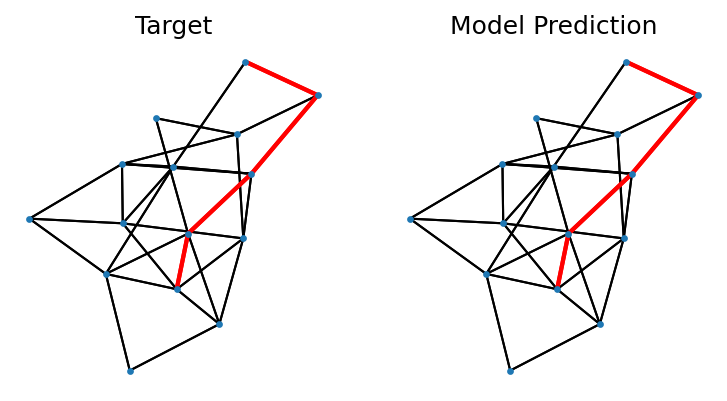

In [ ]:
from scipy.special import expit, logit

fig,ax = plt.subplots(1,2,figsize=(6,3),dpi=150)

ax[0].set_title('Target')
ax[1].set_title('Model Prediction')

net.eval()
net.cpu()

dgl_g = test_ds[5578][0]

output_pred = net(dgl_g).data.numpy()

nx_graph = dgl.to_networkx(dgl_g)
pos = {i: dgl_g.ndata['node_features'][i][:2].data.numpy() for i in range(len(dgl_g.ndata['node_features']))} #nx.spring_layout(nx_graph)
edge_list = [e for i,e in enumerate(nx_graph.edges) if dgl_g.edata['on_path'][i]==1]

edge_widths = np.array([expit(output_pred[i][0]) for i in range(len(output_pred))])
predicted_edge_list = [e for i,e in enumerate(nx_graph.edges) if expit(output_pred[i])[0]>=0.5]

pos = nx.spring_layout(nx_graph)


nx.draw( nx_graph ,pos=pos ,ax=ax[0] ,node_size=5,arrows=False)
nx.draw_networkx_edges(nx_graph,pos=pos,edgelist=edge_list,width=2,edge_color='r',ax=ax[0],arrows=False)

nx.draw( nx_graph ,pos=pos ,ax=ax[1] ,node_size=5,arrows=False)
nx.draw_networkx_edges(nx_graph,pos=pos,edgelist=predicted_edge_list,width=2,edge_color='r',ax=ax[1],arrows=False)

plt.show()

### Once you train your network - 
### you can evaluate on the test dataset, and compute the rate of false positive, false negative, etc,
### most of the edges in the dataset have a label 0, so its quite easy to reach a high true negative rate
### but train until you reach at least 60% true positive rate while maintaining a 90%+ true negative rate, and submit

In [ ]:
test_data_loader = DataLoader(test_ds, batch_size=30, shuffle=True,
                         collate_fn=collate)

In [ ]:
net.cpu()
net.eval()

true_positive = 0
false_positive = 0
true_negative = 0
false_negative = 0
total_positives = 0
total_negatives = 0

for i, (x,y) in enumerate(test_data_loader):
        
        y = y.data.numpy()

        prediction = net(x).cpu().data.numpy()
        
        prediction[prediction >= 0.5] = 1
        prediction[prediction <0.5] = 0
        
        total_positives+=len(np.where( y==1 )[0])
        total_negatives+=len(np.where( y==0 )[0])
        
        true_positive+= len(np.where( (prediction==y) & (y==1) )[0])
        true_negative+= len(np.where( (prediction==y) & (y==0) )[0])
        false_positive+= len(np.where( (prediction!=y) & (y==0) )[0])
        false_negative+= len(np.where( (prediction!=y) & (y==1) )[0])
        
        
print('true positive: ', true_positive/total_positives)
print(false_negative/total_positives)
print('true negative: ', true_negative/total_negatives)
print(false_positive/total_negatives)

true positive:  0.9357230719242463
0.0642769280757537
true negative:  0.9957996516784319
0.00420034832156813


In [ ]:
torch.save(net.state_dict(), 'model1.pt')